- Check the relationship of emission rates estimated by EMIT and EnMAP
- Analyze the clear overpass and plume detections for each HSI

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from itertools import chain
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Relationship between estimations of EnMAP and EMIT

In [3]:
# read the summary data
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv')
df_summary['emission_uncertainty'] = df_summary['emission'] * df_summary['emission_uncertainty(%)'] * 1e-2

In [4]:
df_summary[df_summary['name']=='Pirana']

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year,emission_uncertainty
26,India,Pirana,EMIT,22.981863,72.568043,5.146816,37.885809,1,1,19285.05,0.048327,649995.49,399053.89,Waste Atlas,2013.0,1.949913
27,India,Pirana,PRISMA,22.982893,72.570045,6.589572,34.157645,5,28,19285.05,0.048327,649995.49,399053.89,Waste Atlas,2013.0,2.250842


In [5]:
# df_summary['platform'].isin(['EnMAP', 'EMIT'])

In [6]:
def plot_twogrp(ax, df_summary, grp_name1, grp_name2):
    # get landfills oberved by both EnMAP and EMIT
    # df_emiss_twogrp = df_summary[df_summary['platform'].isin([grp_name1, grp_name2])]
    # df_emiss_twogrp = df_emiss_twogrp[df_emiss_twogrp.groupby('name')['name'].transform('size') > 1]
    df_emiss_twogrp = df_summary.groupby('name').filter(lambda x: set(x['platform']) == {'EMIT', 'EnMAP'})
    print('Number of obs: ', len(df_emiss_twogrp))

    enmap_row = df_emiss_twogrp[df_emiss_twogrp['platform']==grp_name1]
    x = enmap_row['emission'].values
    xerr = enmap_row['emission_uncertainty']

    emit_row = df_emiss_twogrp[df_emiss_twogrp['platform']==grp_name2]
    y = emit_row['emission'].values
    yerr = emit_row['emission_uncertainty']

    # # ---- RMA ------
    # from pylr2 import regress2

    # results = regress2(x, y, _method_type_2="reduced major axis", _need_intercept=False)
    # slope = results['slope']
    # y_pred = results['predict']
    # y_mean = y.mean()
    # SSregression = ((y_pred - y_mean) ** 2).sum()
    # SStotal = ((y - y_mean) ** 2).sum()
    # r_squared = SSregression / SStotal

    # ---- ODR ------
    import scipy.odr as odr

    # Define the linear function
    def linear_function(B, x):
        return B[0] * x #+ B[1]

    # Create a model
    linear_model = odr.Model(linear_function)

    # Create a RealData object with errors
    data = odr.RealData(x, y, sx=xerr, sy=yerr)

    # Set up ODR with the model and data
    odr_instance = odr.ODR(data, linear_model, beta0=[1.])

    # Run the regression
    output = odr_instance.run()

    # Extract the parameter
    slope = output.beta[0]
    slope_err = output.sd_beta[0]

    y_pred = linear_function(output.beta, x)
    y_mean = y.mean()
    SSregression = ((y_pred - y_mean) ** 2).sum()
    SStotal = ((y - y_mean) ** 2).sum()
    r_squared = SSregression / SStotal
    
    # # OLS
    # # Reshape the arrays to 2D
    # x_2d = x.reshape(-1, 1)
    # y_2d = y.reshape(-1, 1)

    # # Create and fit the linear regression model
    # model = LinearRegression(fit_intercept=False)
    # model.fit(x_2d, y_2d)

    # # Get the slope of the linear regression line
    # slope = model.coef_[0][0]

    # # Calculate R-squared
    # r_squared = model.score(x_2d, y_2d)

    l1 = ax.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(x, y, squared=False)
    corr, _ = pearsonr(x, y)

    # l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')
    l2 = ax.axline(xy1=(0, 0), slope=slope, label=f'slope: {slope:.2f} ± {slope_err:.2f} \n r: {corr:.2f}', c='C0')
    handles, labels = ax.get_legend_handles_labels()

    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6)
    # sns.regplot(ax=ax, x=x, y=y, color='C0', ci=95, line_kws={'linewidth':0})

    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    # ax.set_title('CH$_4$ Emission Rate (t h$^{-1}$)')
    ax.set_xlabel(grp_name1)
    ax.set_ylabel(grp_name2)

    # plt.legend()
    ax.legend(handles = handles, labels = labels, loc='lower right')


    return x, y, xerr, yerr

Number of obs:  24


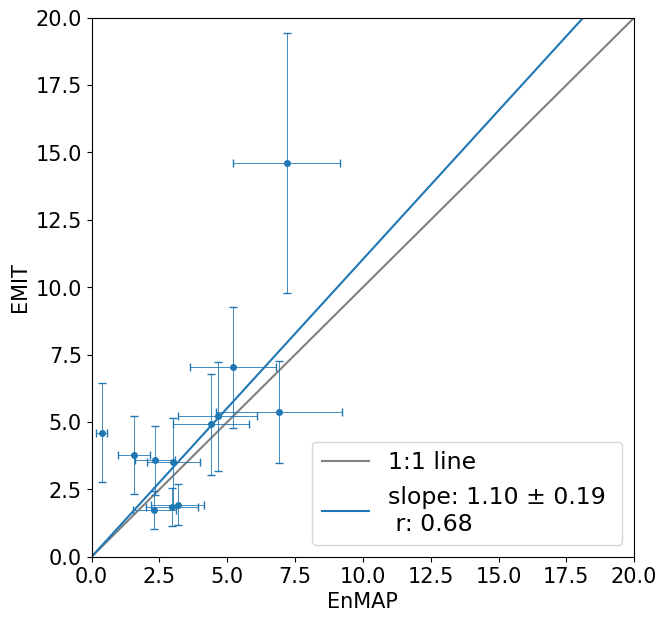

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

_, _, _, _ = plot_twogrp(ax, df_summary, grp_name1='EnMAP', grp_name2='EMIT')
# fig.savefig('../figures/emit_enmap_fit.pdf')

In [8]:
df_summary[(df_summary['emission']>10)&(df_summary['platform']=='EMIT')]

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year,emission_uncertainty
2,Argentina,Norte III,EMIT,-34.527867,-58.623094,20.468392,34.121168,4,4,28528.14,0.045643,900000.0,625026.97,Waste Atlas,2013.0,6.984055
7,Brazil,Caieiras,EMIT,-23.346724,-46.771954,14.248087,36.316468,1,1,NaN,NaN,NaN,NaN,NaN,NaN,5.174402
8,Brazil,Pedreira,EMIT,-23.403698,-46.560783,10.991205,38.411063,1,1,NaN,NaN,NaN,NaN,NaN,NaN,4.221839
19,India,Kanjurmarg,EMIT,19.122178,72.952702,10.853184,34.275801,1,1,3872.44,0.050050,38354.5,77371.17,Global Plastic Watch,2021.0,3.720016
42,Mexico,Tecnosilicatos,EMIT,19.324110,-98.803256,11.221086,41.796843,3,3,NaN,NaN,NaN,NaN,NaN,NaN,4.690060
47,Saudi Arabia,Riyadh,EMIT,24.614397,46.894349,14.615276,33.000785,9,9,16443.35,0.042495,NaN,386950.65,METER/OSM,2022.0,4.823156


In [9]:
# df_summary_two = df_summary[df_summary['platform'].isin(['EMIT', 'EnMAP'])].groupby(['name']).mean().reset_index()
# # df_summary_two['platform'] = 'EMIT and EnMAP'

# df_summary_prisma = df_summary[df_summary['platform']=='PRISMA']
# df_summary_two = df_summary_two[df_summary_two['name'].isin(df_summary_prisma['name'])][['name', 'emission', 'emission_uncertainty']]

# df_summary_two = df_summary_two.rename(columns={'emission': 'EMIT and EnMAP', 'emission_uncertainty': 'EMIT and EnMAP uncertainty'})
# df_summary_prisma = df_summary_prisma[['name', 'emission', 'emission_uncertainty']].rename(columns={'emission': 'PRISMA', 'emission_uncertainty': 'PRISMA uncertainty'})

# df_summary_merge = df_summary_two.merge(df_summary_prisma, on='name')

In [10]:
df_summary_prisma = df_summary[df_summary['platform']=='PRISMA']
df_summary_prisma = df_summary_prisma[['name', 'emission', 'emission_uncertainty']].rename(columns={'emission': 'PRISMA', 'emission_uncertainty': 'PRISMA uncertainty'})

df_summary_enmap = df_summary[df_summary['platform']=='EnMAP']
df_summary_enmap = df_summary_enmap[['name', 'emission', 'emission_uncertainty']].rename(columns={'emission': 'EnMAP', 'emission_uncertainty': 'EnMAP uncertainty'})

df_summary_emit = df_summary[df_summary['platform']=='EMIT']
df_summary_emit = df_summary_emit[['name', 'emission', 'emission_uncertainty']].rename(columns={'emission': 'EMIT', 'emission_uncertainty': 'EMIT uncertainty'})

df_summary_merge = df_summary_prisma.merge(df_summary_enmap, on='name', how='left').merge(df_summary_emit, on='name', how='left')

In [11]:
df_summary_merge

,name,PRISMA,PRISMA uncertainty,EnMAP,EnMAP uncertainty,EMIT,EMIT uncertainty
0,Norte III,21.179515,6.432957,16.911863,4.354786,20.468392,6.984055
1,Kanjurmarg,12.244548,3.866450,6.858385,2.107292,10.853184,3.720016
2,Pirana,6.589572,2.250842,NaN,NaN,5.146816,1.949913
3,Lakhodair,15.495347,4.947171,NaN,NaN,5.410499,2.008705


Number of obs:  24


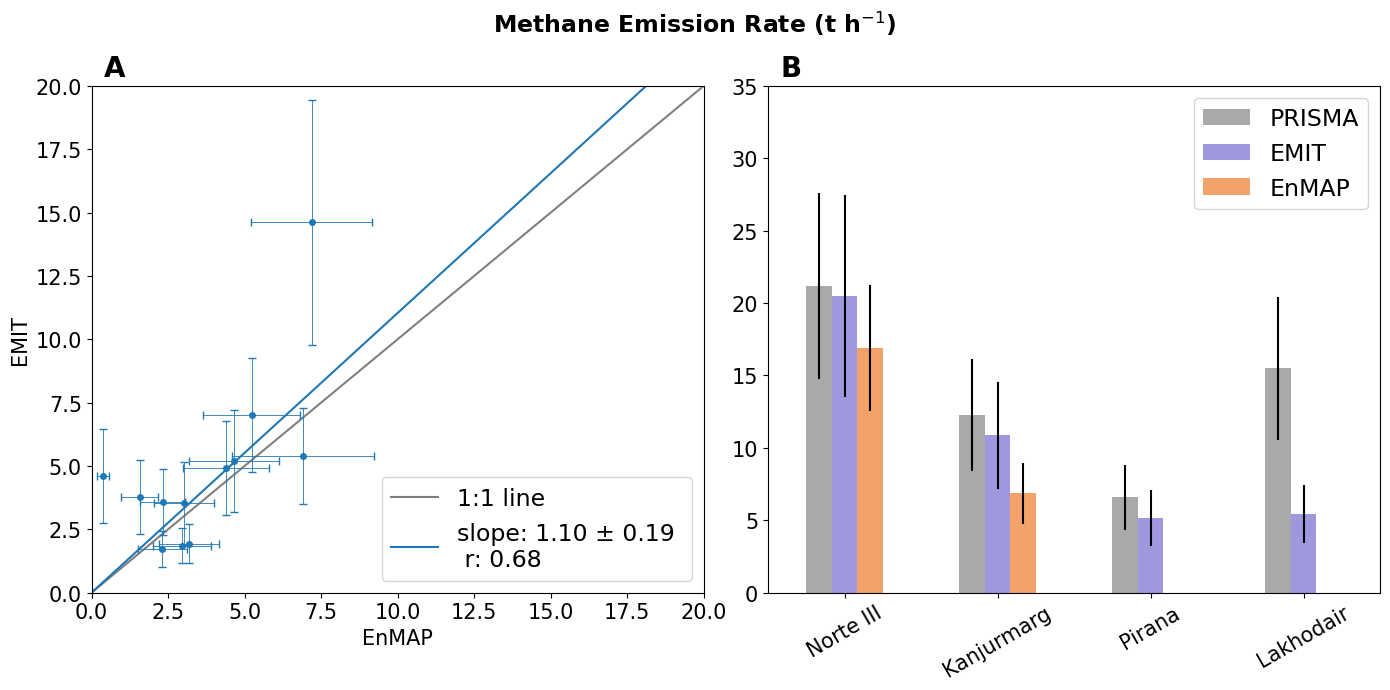

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

ax = axs[0]
_, _, _, _ = plot_twogrp(ax, df_summary, grp_name1='EnMAP', grp_name2='EMIT')

ax = axs[1]

df_summary_merge.plot(ax=ax,
                x='name', y=['PRISMA', 'EMIT', 'EnMAP'],
                yerr=[df_summary_merge['PRISMA uncertainty'],
                      df_summary_merge['EMIT uncertainty'],
                      df_summary_merge['EnMAP uncertainty'],
                      ],
                kind="bar",
                color=['darkgray', '#9f98de', '#f3a26a'],
                rot=30,
                )

ax.set_xlabel('')
ax.set_ylim(0, 35)
plt.suptitle('Methane Emission Rate (t h$^{-1}$)')
ax.set_ylim(ymin=0)

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0.02, 1.02, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
fig.savefig('../figures/hsi_fit.pdf')

## HSI observation numbers

In [13]:
# read the OBS file
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx')

# remove space at end
df_obs['name'] = df_obs['name'].str.strip()

In [14]:
# tropomi hotspots with no observations of HSI (only consider EnMAP and EMIT)
# no_obs_mask = (df['source_tropomi']==1) & (df[['overpass(emit)', 'overpass(enmap)', 'overpass(prisma)']].sum(axis=1) == 0)
no_obs_mask = (df_obs['source_tropomi']==1) & (df_obs[['overpass(emit)', 'overpass(enmap)']].sum(axis=1) == 0)
obs_mask = ~no_obs_mask

# tropomi hotspots with no plume detected by HSI
no_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) == 0) & obs_mask

# plumes only detected by HSI 
hsi_plume_mask = (df_obs['source_tropomi']==0) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0) 

# tropomi hotspots with at least one plume detected by any HSI
both_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0)

# plume mask
plume_mask = df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0

# hotspots mask
hotspots_mask = df_obs['source_tropomi'] == 1

In [15]:
# get the number of plume and clear overpasses for each HSI platform
df_emit_plume_obs = df_obs[plume_mask][['name', 'plume(emit)', 'overpass(emit)']].rename(columns={'plume(emit)': 'plume', 'overpass(emit)': 'overpass'})
df_enmap_plume_obs = df_obs[plume_mask][['name', 'plume(enmap)', 'overpass(enmap)']].rename(columns={'plume(enmap)': 'plume', 'overpass(enmap)': 'overpass'})
df_prisma_plume_obs = df_obs[plume_mask][['name', 'plume(prisma)', 'overpass(prisma)']].rename(columns={'plume(prisma)': 'plume', 'overpass(prisma)': 'overpass'})

# get the number of plume and clear overpasses of TROPOMI hotspots for each HSI platform
df_emit_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(emit)', 'overpass(emit)']].rename(columns={'plume(emit)': 'plume', 'overpass(emit)': 'overpass'})
df_enmap_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(enmap)', 'overpass(enmap)']].rename(columns={'plume(enmap)': 'plume', 'overpass(enmap)': 'overpass'})
df_prisma_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(prisma)', 'overpass(prisma)']].rename(columns={'plume(prisma)': 'plume', 'overpass(prisma)': 'overpass'})

In [16]:
def get_stats_list(df):
    return [df[df['plume']>=1].__len__(), df[(df['plume']==0)&(df['overpass']>0)].__len__(), df[df['overpass']==0].__len__()]

def set_label_white(autotexts):
    for autotext in autotexts:
        autotext.set_color('white')

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d})"

def plot_pie(ax, data, colors=['#f3a26a', '#9f98de', 'silver']):
    # color: the color of pie patch
    #   order: >= 1, no plume, no OBS

    # get number > 0 part
    positive_index = np.nonzero(data)[0]
    data = [data[i] for i in positive_index]
    colors = [colors[i] for i in positive_index]

    patches, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                   textprops={'fontsize': 13, 'weight':'bold'}, colors=colors)
    set_label_white(autotexts)

    return patches

In [17]:
emit_plume_stats_list = get_stats_list(df_emit_plume_obs)
enmap_plume_stats_list = get_stats_list(df_enmap_plume_obs)
prisma_plume_stats_list = get_stats_list(df_prisma_plume_obs)

emit_hotspot_stats_list = get_stats_list(df_emit_hotspot_obs)
enmap_hotspot_stats_list = get_stats_list(df_enmap_hotspot_obs)
prisma_hotspot_stats_list = get_stats_list(df_prisma_hotspot_obs)

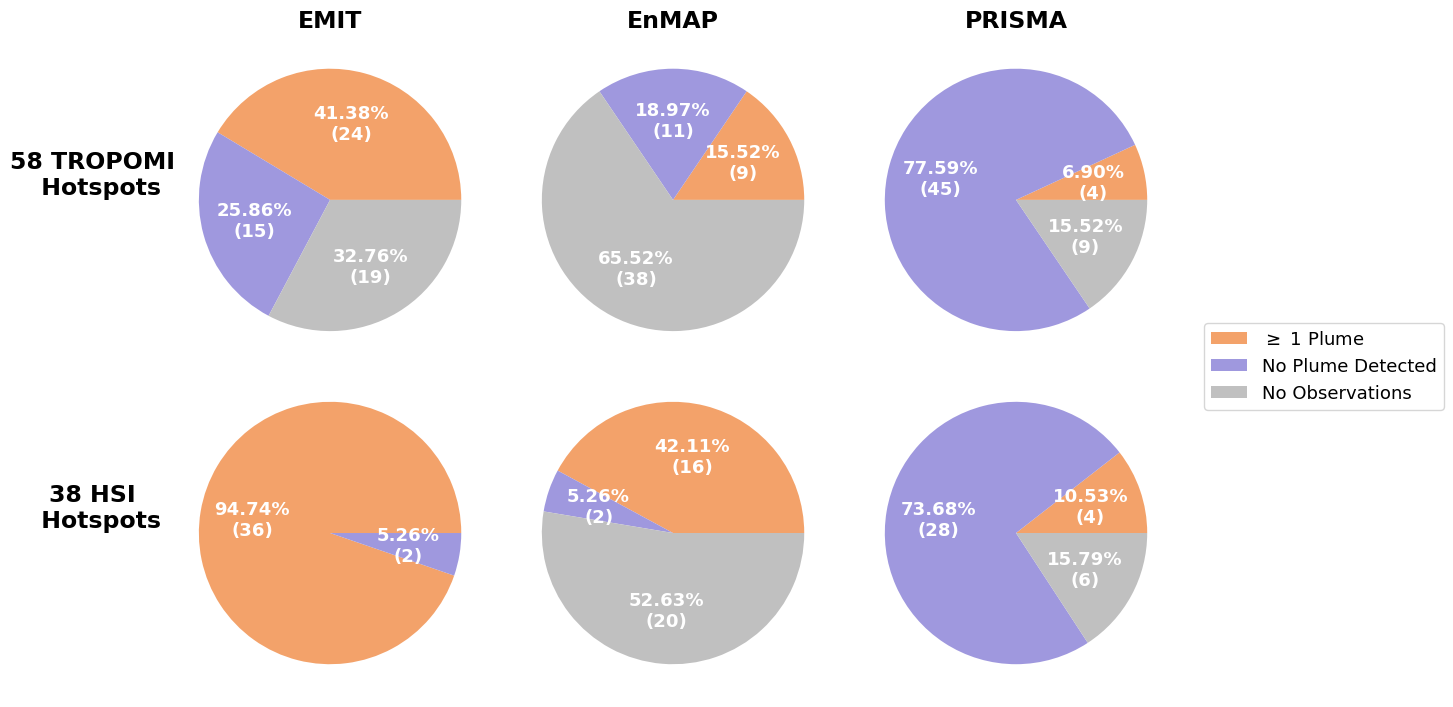

In [18]:
# pie data: plume >= 1, No Plume: plume=0, No OBS: overpass=0
legend_labels = ['$\geq$ 1 Plume', 'No Plume Detected', 'No Observations']
col_labels = ['EMIT', 'EnMAP', 'PRISMA']
row_labels = [f"{len(df_obs[df_obs['source_tropomi']==1])} TROPOMI \n Hotspots",
              f"{len(df_obs[plume_mask])} HSI \n Hotspots"]

# add row and column labels
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=0, size=font_size, fontweight='bold', labelpad=50)

axs = axs.flatten()

plot_pie(axs[0], emit_hotspot_stats_list)
plot_pie(axs[1], enmap_hotspot_stats_list)
plot_pie(axs[2], prisma_hotspot_stats_list)
plot_pie(axs[3], emit_plume_stats_list)
plot_pie(axs[4], enmap_plume_stats_list)
patches = plot_pie(axs[5], prisma_plume_stats_list)


fig.subplots_adjust(hspace=-0.7)

legend = fig.legend(patches, legend_labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 13}
          )

fig.tight_layout()
# fig.patch.set_facecolor('w')
# fig.patch.set_alpha(0)

fig.savefig('../figures/hsi_plume_stats.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')